## Analyze Taylor Swift Lyrics with Python
- Course: [Codecademy](https://www.codecademy.com/courses/case-study-analyze-taylor-swift-lyrics/projects/analyze-taylor-swift-lyrics) 
- Dataset: [Lyrics All Albums](https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums)

In [46]:
# Import libraries

%matplotlib inline

import pandas as pd
import os
import string
import collections
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

### 1. Load the dataset

In [47]:
def get_all_csv_files():
    files = os.listdir('./csv')
    files_csv = [file for file in files if file.endswith('.csv')]
    return files_csv

list_albums = get_all_csv_files()

def create_lyrics_dataframe(list_albums):
    lyrics = pd.DataFrame()
    for album in list_albums:
        if album.startswith('0'):
            album = pd.read_csv(f'./csv/{album}')
            lyrics = pd.concat([lyrics, album], axis=0)
    midnight_album = pd.read_csv('./csv/10-midnights.csv', encoding='latin-1')
    lyrics = pd.concat([lyrics, midnight_album], axis=0)
    return lyrics

lyrics = create_lyrics_dataframe(list_albums)

Inspect the Dataset

In [48]:
first_five_rows = lyrics[:5]
first_five_rows

,album_name,track_title,track_n,lyric,line
0,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1
1,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2
2,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3
3,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4
4,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5


In [49]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9370 entries, 0 to 1011
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9370 non-null   object
 1   track_title  9370 non-null   object
 2   track_n      9370 non-null   int64 
 3   lyric        9370 non-null   object
 4   line         9370 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 439.2+ KB


In [50]:
# We can change the type of line and track_n
lyrics['line'] = lyrics['line'].astype('int8')
lyrics['track_n'] = lyrics['track_n'].astype('int8')

lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9370 entries, 0 to 1011
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9370 non-null   object
 1   track_title  9370 non-null   object
 2   track_n      9370 non-null   int8  
 3   lyric        9370 non-null   object
 4   line         9370 non-null   int8  
dtypes: int8(2), object(3)
memory usage: 311.1+ KB


- There are no missing values. We can find the name of each album, the track, and the line in which lyric appears. 
We need to get the year of each album.
- Change type for track_n and line because it only takes number between -127 and 127. We can reduce memory usage

### 2. Adding year of each album

In [51]:
list_albums = list(lyrics['album_name'].unique())
list_albums

['Taylor Swift',
 'Fearless (Taylor’s Version)',
 'Speak Now (Deluxe)',
 'Red (Deluxe Edition)',
 '1989 (Deluxe)',
 'reputation',
 'Lover',
 'folklore (deluxe version)',
 'evermore (deluxe version)',
 'midnights',
 'midnights (3am edition)']

In [52]:
# Replace and uniform the midnights album
lyrics['album_name'] = lyrics['album_name'].replace('midnights (3am edition)', 'midnights')

In [53]:
def album_year_release(row):  
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    elif 'midnights' in row['album_name']:
        return '2022'
        
    return 'No Date'

# applied function to get the year
lyrics['album_year'] = lyrics.apply(lambda row: album_year_release(row), axis=1).astype(int)


In [54]:
# Inspect if we have the year of each album in 'album_year' column
lyrics.head(5)

,album_name,track_title,track_n,lyric,line,album_year
0,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


### 3. Clear the lyrics text and capitalize album_name
- To accurately count keyword mentions, we need to make everything lowercase everything, remove punctuation, and exclude stop words.

In [55]:
# Change lyrcis to lowercase into a new column clean_lyrics 
lyrics['clean_lyric'] = lyrics['lyric'].str.lower()

# Remove punctuantion
lyrics['clean_lyric'] = lyrics['clean_lyric'].str.replace('[^\w\s]','', regex=True)

# Capitalize album_name
lyrics['album_name'] = lyrics['album_name'].str.capitalize()


In [56]:
# remove stop words
stop = ['the', 'a', 'this', 'that', 'to', 'is', 'am', 'was', 'were', 'be', 'being', 'been']

lyrics['clean_lyric'] = lyrics['clean_lyric'].\
                            apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Taylor swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006,he said way my blue eyes shined
1,Taylor swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006,put those georgia stars shame night
2,Taylor swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006,i said thats lie
3,Taylor swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006,just boy in chevy truck
4,Taylor swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006,had tendency of gettin stuck


In [57]:
# most exclude too many words to be appropriate for song lyric analysis
# from sklearn.feature_extraction import text
# skl_stop = text.ENGLISH_STOP_WORDS
# print(skl_stop)

### 4. Find keyword mentions
- We will first count how many times the word midnight ocurrs in Taylor Swift's lyrics

In [58]:
lyrics['midnight'] = lyrics['clean_lyric'].str.contains('midnight').astype(int)
counts_midnight = sum(lyrics['midnight'])
print(f'Count midnight: {counts_midnight}')

Count midnight: 20


Midnight is not very common. It only appears 20 times

### 5. Expand the keyword list
- Midnight might not be the only way that Taylor Swift has talked about night. We need to expand our list. We've made a list of night words and day words.

In [59]:
# We get a list for each time or part of the day
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

     night  day  time
Yes    287  387    35


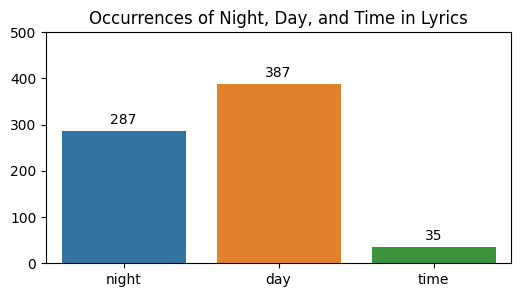

In [60]:
# Count how many times occurs from the list of day, night and time 
night_pattern = '|'.join(night)
day_pattern  = '|'.join(day)
time_pattern  = '|'.join(time)

lyrics['night'] = lyrics['clean_lyric'].str.contains(night_pattern, regex=True).astype(int)
lyrics['day'] = lyrics['clean_lyric'].str.contains(day_pattern, regex=True).astype(int)
lyrics['time'] = lyrics['clean_lyric'].str.contains(time_pattern , regex=True).astype(int)

night_count = lyrics['night'].value_counts()
day_count = lyrics['day'].value_counts()
time_count = lyrics['time'].value_counts()

counts = pd.concat([night_count, day_count , time_count], axis=1)
counts.index = ['No', 'Yes']

print(counts[counts.index == 'Yes'])

yes_counts = counts[counts.index == 'Yes']

plt.figure(figsize=(6,3))
plots = sns.barplot(data=yes_counts.T.reset_index(), x='index', y='Yes')

for bar in plots.patches:
        plots.annotate(f'{bar.get_height():.0f}', # value
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

plt.title('Occurrences of Night, Day, and Time in Lyrics')
plt.xlabel('')
plt.ylabel('')
plt.ylim(0, 500)
plt.show()

Taylor Swift has referenced time alot, there's enough mentions for us to potentially spot some trends. Also, she has mentioned day far more than night. This might be because of the search terms, so we might consider revisiting the list. Or it could be because she is actually more focused on day and light than she is on night and dark.

### 6. Visualize how Taylor Swift's mentions of time have changed over time
- Now that we know that she has referenced time, we can see if that has changed, and if she has been dropping any hints about her upcoming album.

In [61]:
yearly_mentions = lyrics.groupby(['album_year'])\
                                   .sum()[['night', 'day', 'time']]\
                                   .reset_index()

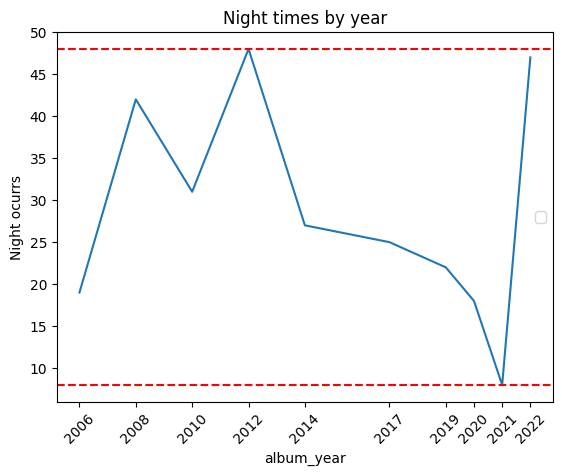

In [62]:
ax = yearly_mentions.plot(kind='line', x='album_year', y='night')

ax.set_title('Night times by year')
ax.set_ylabel('Night ocurrs')

# Set x-axis ticks for each year and rotate 45
ax.set_xticks(yearly_mentions['album_year'].dropna().unique())
ax.set_xticklabels(ax.get_xticks(), rotation=45)

ax.axhline(y=yearly_mentions['night'].max(), color='red', linestyle='--')
ax.axhline(y=yearly_mentions['night'].min(), color='red', linestyle='--')


plt.legend('')
plt.show()

It looks like there was a peak in her mentioning night around 2012. It seems like those mentions have become less prevalent over time, with an actual dip in 2019! We had expected midnight to appear more often around then, based on rumors that she plans everything 3 years out.

### 7. What albums are the most night/day focused?

- Now that we have a table of counts, it's very easy to figure out which albums have the most mentions of day or night. But our DataFrame only has the years, not the album names. We need to add those back in.

In [63]:
# read album_year_name.csv
year_name = pd.read_csv('./csv/album_year_name.csv', encoding='latin-1')

# sort both dataframes by year
yearly_mentions.sort_values(by='album_year', ascending=True, inplace=True)
year_name.sort_values(by='album_year', ascending=True, inplace=True)

# add the new column for album name
yearly_mentions['album_name'] = year_name['album_name']

In [64]:
# sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values('night', ascending=False)[['album_year', 'night', 'album_name']]

,album_year,night,album_name
3,2012,48,Red (Deluxe Edition)
9,2022,47,Midnights
1,2008,42,Fearless (Taylors Version)
2,2010,31,Speak Now (Deluxe)
4,2014,27,1989 (Deluxe)
5,2017,25,reputation
6,2019,22,Lover
0,2006,19,Taylor Swift
7,2020,18,evermore (deluxe version)
8,2021,8,folklore (deluxe version)


Her most "nightly" album was reputation in 2012, whereas her least nightly album was also the one right before Midnight. Has she been saving all her night-related lyrics for the past 3 years?

In [65]:
# sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values('day', ascending=False)[['album_year', 'day', 'album_name']]

,album_year,day,album_name
1,2008,65,Fearless (Taylors Version)
2,2010,53,Speak Now (Deluxe)
3,2012,53,Red (Deluxe Edition)
6,2019,46,Lover
4,2014,41,1989 (Deluxe)
7,2020,38,evermore (deluxe version)
0,2006,25,Taylor Swift
5,2017,25,reputation
9,2022,24,Midnights
8,2021,17,folklore (deluxe version)


It seems like her older work focused on day much more than her more recent. There was a period of time (2008-2012) when she was really focused on day, but it seems to have become less central to her work more recently.

### 8. Compare day to night mentions

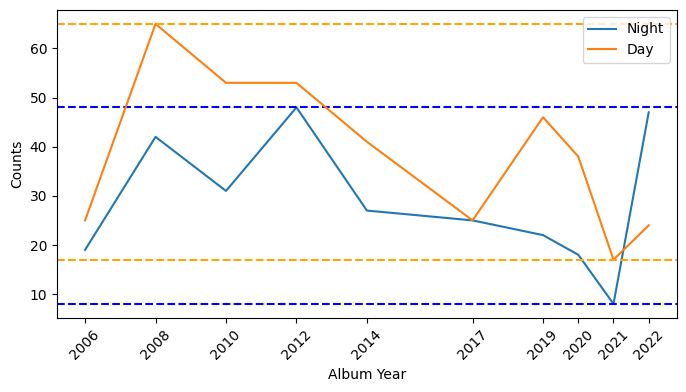

In [66]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(yearly_mentions['album_year'], yearly_mentions['night'], label='Night')
ax.axhline(y=yearly_mentions['night'].max(), color='blue', linestyle='--')
ax.axhline(y=yearly_mentions['night'].min(), color='blue', linestyle='--')

ax.plot(yearly_mentions['album_year'], yearly_mentions['day'], label='Day')
ax.axhline(y=yearly_mentions['day'].max(), color='orange', linestyle='--')
ax.axhline(y=yearly_mentions['day'].min(), color='orange', linestyle='--')

ax.set_xlabel('Album Year')
ax.set_ylabel('Counts')

# Set x-axis ticks for each year and rotate 45
ax.set_xticks(yearly_mentions['album_year'].dropna().unique())
ax.set_xticklabels(ax.get_xticks(), rotation=45)

ax.legend()

plt.show()


Well this is interesting. We see a decrease of both period from 2014 to 2017. But in 2017 it increase the mention in Day in that album. After that year, it decrease again until the last release year who album was midnights were she mentioned a lot of nights terms.

### 9. Investigate position of day vs. night mentions within albums

- Maybe her references to time aren't always about the year that she released the album, but the ebb and flow of the album itself. Let's plot where, within each album, references to day and night occur.

In [67]:
# create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + lyrics['line'] / 1000

positional_mentions = lyrics.groupby('position').sum().reset_index()

<Figure size 2500x1000 with 0 Axes>

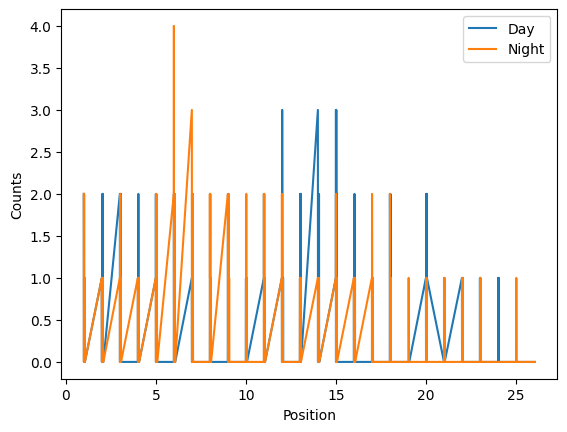

In [68]:
fig = plt.gcf()
fig.set_size_inches(25,10)

fig, ax = plt.subplots()

ax.plot(positional_mentions['position'], positional_mentions['day'], label='Day')
ax.plot(positional_mentions['position'], positional_mentions['night'], label='Night')

ax.set_xlabel('Position')
ax.set_ylabel('Counts')

ax.legend()

plt.show()

We can't see any strong trends here. Best to move on.

### 10. Tokenize the Lyrics
- It's great to know how much she has focused on day and night, but we would also like to do a little more sophisticated analysis. Before we can work with our cleaned lyrics, we will have to tokenize them. Tokenization is a special way of breaking up words that is a little more nuanced than just using white space.
- We will use the word_tokenize function from NLTK (the Natural Language ToolKit)

In [69]:
lyrics['lyrics_tok'] = lyrics['clean_lyric'].str.split(' ')

In [70]:
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok
0,Taylor swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006,he said way my blue eyes shined,0,0,0,0,1.001,"[he, said, way, my, blue, eyes, shined]"
1,Taylor swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006,put those georgia stars shame night,0,1,0,0,1.002,"[put, those, georgia, stars, shame, night]"
2,Taylor swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006,i said thats lie,0,0,0,0,1.003,"[i, said, thats, lie]"
3,Taylor swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006,just boy in chevy truck,0,0,0,0,1.004,"[just, boy, in, chevy, truck]"
4,Taylor swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006,had tendency of gettin stuck,0,0,0,0,1.005,"[had, tendency, of, gettin, stuck]"


In [71]:
# Determine what words overall are the most frequently used words
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

# Count the number of times each word appears
word_frequency = collections.Counter(word_list)

# Sort the word frequencies to find out the most common words she's used
word_frequency = word_frequency.most_common()

word_frequency

[('you', 3058),
 ('i', 2909),
 ('and', 1844),
 ('me', 1153),
 ('it', 1029),
 ('in', 1003),
 ('my', 927),
 ('your', 689),
 ('of', 667),
 ('all', 590),
 ('but', 581),
 ('im', 568),
 ('like', 552),
 ('on', 538),
 ('we', 538),
 ('know', 477),
 ('so', 454),
 ('oh', 447),
 ('its', 444),
 ('dont', 432),
 ('when', 417),
 ('never', 384),
 ('just', 374),
 ('youre', 367),
 ('for', 348),
 ('with', 332),
 ('love', 324),
 ('now', 321),
 ('what', 320),
 ('up', 304),
 ('time', 286),
 ('out', 286),
 ('cause', 283),
 ('back', 276),
 ('if', 276),
 ('at', 275),
 ('no', 239),
 ('are', 230),
 ('one', 222),
 ('do', 220),
 ('down', 218),
 ('got', 214),
 ('see', 211),
 ('say', 211),
 ('think', 202),
 ('they', 197),
 ('baby', 191),
 ('want', 189),
 ('go', 188),
 ('can', 188),
 ('not', 177),
 ('come', 175),
 ('could', 174),
 ('wanna', 170),
 ('have', 169),
 ('there', 168),
 ('right', 166),
 ('yeah', 166),
 ('he', 165),
 ('ill', 165),
 ('cant', 164),
 ('said', 158),
 ('ever', 150),
 ('get', 145),
 ('would', 144),

She mostly talks about you and then herself, while that's not surprising, it also tells us that she's mostly writing about relationships and her realtionships with others.

### 11. Analyze Lyric Sentiment
- To better understand how she thinks and feels about day and night, we want to know which one she writes about more favorably.
- We are going to use the pre-trained sentiment classifier that comes with NLTK. It's it trained on tweets and therefore best for short text. It return 4 values: positive, negative, neutral, and compound. Compound will be of special interest to us. It is the normalized sum of positive and negative.

In [72]:
# run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [73]:
# Applied SentimentIntensityAnalyzer to get the sentiment analysis for each lyric
sia = SentimentIntensityAnalyzer()
lyrics['polarity'] = lyrics.apply(lambda row: sia.polarity_scores(row['clean_lyric']), axis=1)

In [74]:
# Transform the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,neg,neu,pos,compound
0,Taylor swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006,he said way my blue eyes shined,0,0,0,0,1.001,"[he, said, way, my, blue, eyes, shined]",0.000,1.000,0.00,0.0000
1,Taylor swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006,put those georgia stars shame night,0,1,0,0,1.002,"[put, those, georgia, stars, shame, night]",0.383,0.617,0.00,-0.4767
2,Taylor swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006,i said thats lie,0,0,0,0,1.003,"[i, said, thats, lie]",0.000,1.000,0.00,0.0000
3,Taylor swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006,just boy in chevy truck,0,0,0,0,1.004,"[just, boy, in, chevy, truck]",0.000,1.000,0.00,0.0000
4,Taylor swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006,had tendency of gettin stuck,0,0,0,0,1.005,"[had, tendency, of, gettin, stuck]",0.333,0.667,0.00,-0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,Midnights,dear reader,20,"You should find another guiding light, guiding...",34,2022,you should find another guiding light guiding ...,0,0,1,0,20.034,"[you, should, find, another, guiding, light, g...",0.000,1.000,0.00,0.0000
1008,Midnights,dear reader,20,But I shine so bright,35,2022,but i shine so bright,0,0,1,0,20.035,"[but, i, shine, so, bright]",0.000,0.370,0.63,0.7279
1009,Midnights,dear reader,20,"You should find another, you should find anoth...",36,2022,you should find another you should find anothe...,0,0,1,0,20.036,"[you, should, find, another, you, should, find...",0.000,1.000,0.00,0.0000
1010,Midnights,dear reader,20,"Find another, you should find another",37,2022,find another you should find another,0,0,0,0,20.037,"[find, another, you, should, find, another]",0.000,1.000,0.00,0.0000


### 12. Corpus Sentiment Analysis
- Now that we have sentiment for all of her lyrics, let's learn more about her overall sentiment, as well as how that has change throughout her career.

In [75]:
# Calculate overall sentiment for pos, neg, sentiment
pos = round(sum(lyrics['pos']),2)
neg = round(sum(lyrics['neg']),2)
compound = round(sum(lyrics['compound']),2)

print('pos:', pos)
print('neg:', neg)
print('compound:', compound)

pos: 1235.21
neg: 798.94
compound: 486.39


Overall Taylor Swift's lyrics are mostly positive!

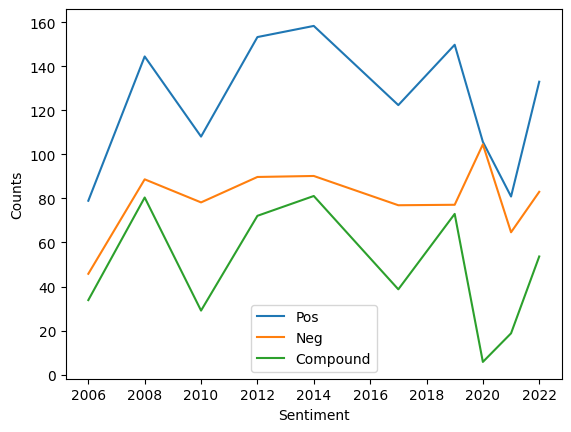

In [76]:
# Visualize over time

df_group = lyrics.groupby(['album_year']).sum().reset_index()
df_sentiment = df_group[['album_year', 'neg', 'neu', 'pos', 'compound']]

fig, ax = plt.subplots()

ax.plot(df_sentiment['album_year'], df_sentiment['pos'], label='Pos')
ax.plot(df_sentiment['album_year'], df_sentiment['neg'], label='Neg')
ax.plot(df_sentiment['album_year'], df_sentiment['compound'], label='Compound')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Counts')
ax.legend()
plt.show()

Her degree of positivity has really fluctuated over time. Her 2020 album was by far the least positive, though all of her albums are actually positive.

### 13. Day or Night? Positive or Negative?
- Finally the big reveal. Does Taylor Swift write more positively about day or night?
- Using compound we can respond this. The compound score is a single metric that provides a quick understanding of the overall sentiment of a piece of text, considering both positive and negative expressions.

In [77]:
# create a DataFrame filtered for only night mentions
df_night = lyrics[lyrics['night'] == 1]

#create a DataFrame filtered for only day mentions
df_day = lyrics[lyrics['day'] == 1]

# print the length of the night and day DataFrames
print('Length night:', len(df_night))
print('Length day:', len(df_day))

Length night: 287
Length day: 387


In [78]:
# calculate the sentiment of each day and night DataFrame from the compound values

night_sentiment = sum(df_night['compound'])
day_sentiment = sum(df_day['compound'])

print("Night sentiment: ", night_sentiment)
print("Day_sentiment: ", day_sentiment)


Night sentiment:  19.767700000000033
Day_sentiment:  26.57999999999999


In [79]:
# Plot a line plot for Day and Night
df_group_night = df_night.groupby(['album_year']).sum().reset_index()
df_sentiment_night = df_group_night[['album_year', 'neg', 'neu', 'pos', 'compound']]

df_group_day = df_day.groupby(['album_year']).sum().reset_index()
df_sentiment_day = df_group_day[['album_year', 'neg', 'neu', 'pos', 'compound']]

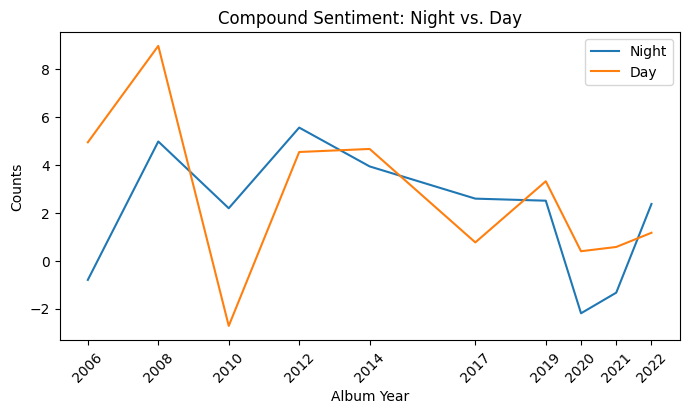

In [80]:
fig, axes = plt.subplots(figsize=(8, 4))

sns.lineplot(x='album_year', y='compound', data=df_sentiment_night, label='Night', ax=axes)
sns.lineplot(x='album_year', y='compound', data=df_sentiment_day, label='Day', ax=axes)

axes.set_title('Compound Sentiment: Night vs. Day')
axes.set_xlabel('Album Year')
axes.set_ylabel('Counts')

axes.set_xticks(df_sentiment_night['album_year'].dropna().unique())
axes.set_xticklabels(axes.get_xticks(), rotation=45)

axes.legend()

plt.show()

In [81]:
# Get album from 2008 and 2012
album_2008 = lyrics[lyrics['album_year'] == 2008][['album_name']].iloc[0,0]
album_2012 = lyrics[lyrics['album_year'] == 2012][['album_name']].iloc[0,0]
album_2020 = lyrics[lyrics['album_year'] == 2020][['album_name']].iloc[0,0]

print('Album 2008:', album_2008)
print('Album 2012:', album_2012)
print('Album 2020:', album_2020)

Album 2008: Fearless (taylor’s version)
Album 2012: Red (deluxe edition)
Album 2020: Evermore (deluxe version)


- She's still overall more positive in her sentiment about day than night!
- The most difference are in the albums 2008 and 2010. In 2008 ('Fearless (taylor’s version)'), she has more positive in her sentiment about day than night. In 2012 (Red (deluxe edition)) it was in reverse.
- In 2020 it get back. More positive sentiment about day than night. Her album was Evermore (deluxe version)